# Modeling

## Objective
The objective of this notebook is to train and evaluate machine learning models
to predict life expectancy based on the preprocessed dataset.

We start with a simple baseline model to establish a reference performance,
then compare it with more advanced models.


In [8]:
import numpy as np

data = np.load('../data/processed/model_data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']


## Baseline Model: Linear Regression


In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [10]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

train_metrics = evaluate_model(y_train, y_train_pred)
test_metrics = evaluate_model(y_test, y_test_pred)

train_metrics, test_metrics


({'MAE': 2.674700617198705,
  'RMSE': 3.537332469915079,
  'R2': 0.863530224466024},
 {'MAE': 2.7063691365585245,
  'RMSE': 3.541716487957774,
  'R2': 0.8549844814617571})

In [12]:
import joblib
joblib.dump(lr,"../Models/Linear_Regression_model.pkl")


['../Models/Linear_Regression_model.pkl']

If a simple linear model achieves strong performance, the preprocessing pipeline is likely well-designed.

# Advanced Model

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [14]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)


In [15]:
rf_train_metrics = evaluate_model(y_train, y_train_pred_rf)
rf_test_metrics = evaluate_model(y_test, y_test_pred_rf)

rf_train_metrics, rf_test_metrics


({'MAE': 0.4301426131511556,
  'RMSE': 0.6909855890896971,
  'R2': 0.9947925789290328},
 {'MAE': 1.065483788395902,
  'RMSE': 1.7029923372103766,
  'R2': 0.9664716423151892})

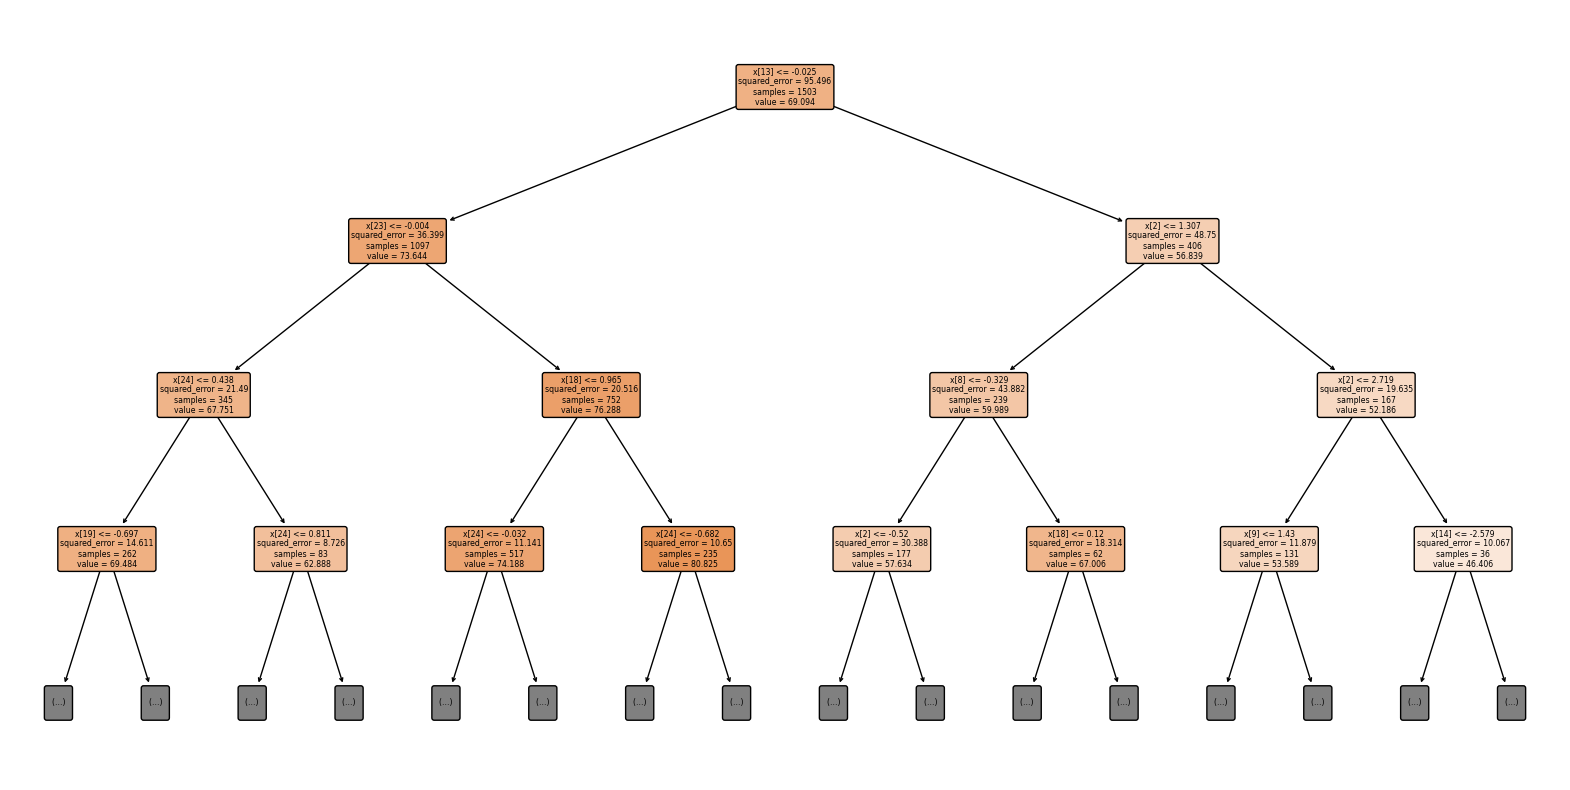

In [16]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree = rf.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(
    tree,
    filled=True,
    rounded=True,
    max_depth=3
)
plt.show()


In [17]:
import pandas as pd

comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE (Test)': [test_metrics['MAE'], rf_test_metrics['MAE']],
    'RMSE (Test)': [test_metrics['RMSE'], rf_test_metrics['RMSE']],
    'R2 (Test)': [test_metrics['R2'], rf_test_metrics['R2']]
})

comparison_df


,Model,MAE (Test),RMSE (Test),R2 (Test)
0,Linear Regression,2.706369,3.541716,0.854984
1,Random Forest,1.065484,1.702992,0.966472


# Hyperparameter Tuning Using Random Search

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


In [19]:
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,          
    cv=5,              
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [20]:
best_params = random_search.best_params_
print(best_params)


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [21]:
best_rf = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=400,
                      n_jobs=-1, random_state=42)

In [22]:
y_train_pred_best_rf = best_rf.predict(X_train)
y_test_pred_best_rf = best_rf.predict(X_test)

train_metrics = evaluate_model( y_train, y_train_pred_best_rf)
test_metrics  = evaluate_model( y_test, y_test_pred_best_rf)

print("Train Metrics:", train_metrics)
print("Test Metrics:", test_metrics)


Train Metrics: {'MAE': 0.43233429666813883, 'RMSE': 0.6791654052832905, 'R2': 0.9949692141785884}
Test Metrics: {'MAE': 1.0531921183036814, 'RMSE': 1.6471357521017946, 'R2': 0.9686349718841872}


In [23]:
import joblib

joblib.dump(best_rf,"../Models/random_forest_best_model.pkl")


['../Models/random_forest_best_model.pkl']